In [1]:
%pylab inline
%load_ext Cython

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree
import seaborn

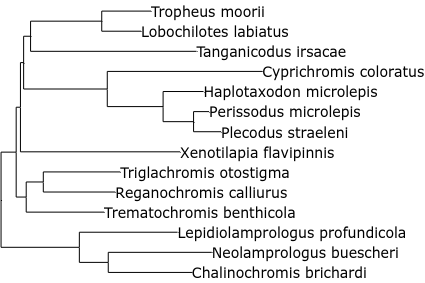

In [3]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( '../fishpoo/mcgee_trimmed.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [4]:
#T = SuchTree( 'SuchTree/tests/test.tree')
T = SuchTree( '../fishpoo/mcgee_trimmed.tree' )

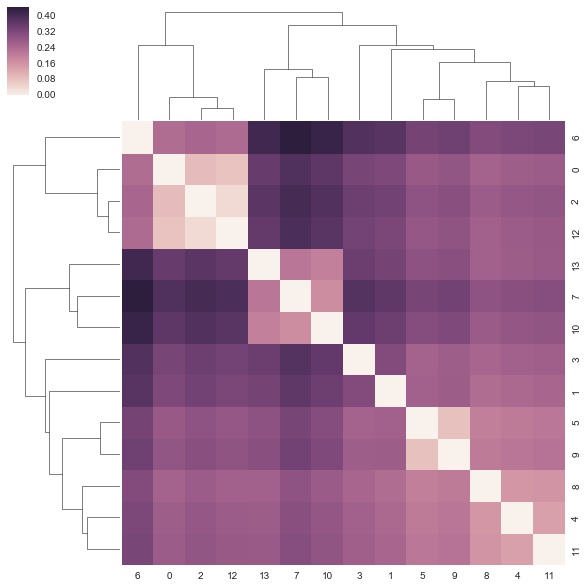

In [5]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )
        
seaborn.clustermap(D1)

In [6]:
T1 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )

print 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) )

nodes : 108653, leafs : 54327


In [7]:
%%cython
import cython

def correlation( double[:] x, double[:] y ) :
    try :
        return _correlation( x, y )
    except ZeroDivisionError :
        return 0.0

@cython.boundscheck(False)
cdef double _correlation( double[:] x, double[:] y ) :
    cdef unsigned int n = len(x)
    cdef unsigned long j
    cdef float yt,xt,t,df
    cdef float syy=0.0,sxy=0.0,sxx=0.0,ay=0.0,ax=0.0
    with nogil :
        for j in xrange(n) :
            ax += x[j]
            ay += y[j]
        ax /= n
        ay /= n
        for j in xrange(n) :
            xt=x[j]-ax
            yt=y[j]-ay
            sxx += xt*xt
            syy += yt*yt
            sxy += xt*yt
        return sxy/((sxx*syy)+1.0e-20)**(0.5)

In [8]:
import pandas as pd

def foundon( df  ) :
    s = df.unstack()
    return s[ s > 0].to_dict().keys()

links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

In [9]:
F = map( lambda x : (T1.leafs[x[0]], T.leafs[x[1]]), foundon(links) )

In [10]:
i = 9979

clade_set = set(T1.get_leafs(i))

filter( lambda x : x[0] in clade_set, F )

[(9976, 16),
 (9976, 4),
 (9978, 16),
 (9978, 6),
 (9974, 14),
 (9972, 4),
 (9984, 4),
 (9980, 6),
 (9974, 16),
 (9982, 4),
 (9980, 8),
 (9984, 24),
 (9980, 18),
 (9972, 26),
 (9976, 6),
 (9980, 26),
 (9972, 2),
 (9976, 14),
 (9978, 14)]

In [48]:
from itertools import combinations
from intbitset import intbitset

N = len(list(T1.get_internal_nodes()))

def paired_distances( id ) :
    clade = intbitset(list(T1.get_leafs(id)))
    if len(clade) > 1000 : return None 
    if len(clade) < 6    : return None
    l = filter( lambda x : x[0] in clade, F )
    nl = len(l)
    if nl < 10 : return None
    gpairs = zeros( ((nl*(nl-1))/2,2), dtype=int )
    hpairs = zeros( ((nl*(nl-1))/2,2), dtype=int )
    for n,((g1,h1),(g2,h2)) in enumerate(combinations( l, 2 )) :
        gpairs[n,0] = g1
        gpairs[n,1] = g2
        hpairs[n,0] = h1
        hpairs[n,1] = h2
    gd = T1.distances( gpairs )
    hd = T.distances(  hpairs )
    return { 'length' : len(clade), 'n_links' : len(l), 'guest distances' : gd, 'host distances' : hd }

In [49]:
from threading import Thread
from Queue import Queue
import pyprind

n = 2
m = 12

work_q = Queue()
done_q = Queue()

progbar = pyprind.ProgBar( N, monitor=True, title='computing distances...' )

for id in T1.get_internal_nodes() :
    work_q.put( id )

for i in xrange( n ) :
    work_q.put( 'STOP' )

def worker( work_q, done_q ) :
    for id in iter( work_q.get, 'STOP' ) :
        result = paired_distances( id )
        progbar.update()
        if not result : continue
        row = {}
        pr,pp = correlation( result['guest distances'], result['host distances'] ),0
        sr,sp = 0,0
        row[ 'pearsonr' ] = pr
        row[ 'pearsonp' ] = pp
        row[ 'spearmanr' ] = sr
        row[ 'spearmanp' ] = sp
        row[ 'length' ] = result[ 'length' ]
        row[ 'n_links' ] = result[ 'n_links' ]
        row[ 'id' ] = id
        done_q.put( row )
    return True

threads = []

for i in xrange( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

results = filter( lambda x : type(x) != Exception, iter( done_q.get, 'STOP' ) )

computing distances...
0%                          100%
[##########                    ] | ETA: 01:37:46

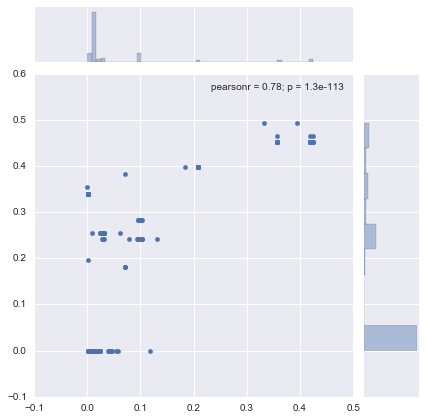

In [86]:
result = paired_distances( sorted(results, key=lambda x : x['pearsonr'] )[-1]['id'] )
seaborn.jointplot(result['guest distances'], result['host distances'] )

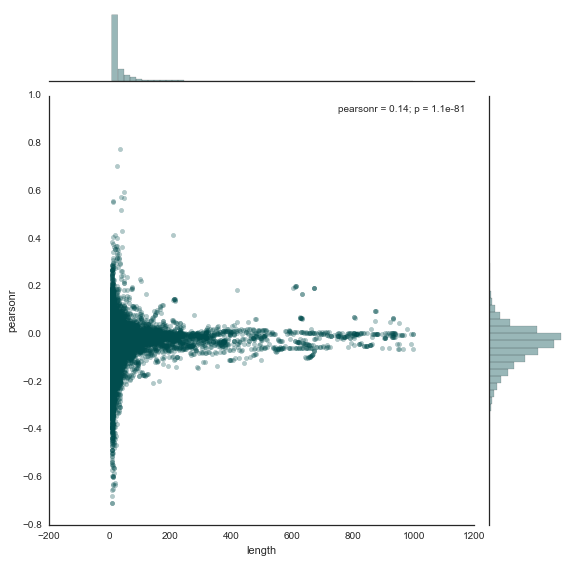

In [51]:
R = pd.DataFrame( results )

with seaborn.axes_style("white"):
    seaborn.jointplot( 'length', 'pearsonr', data=R, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3, size=8 )

In [82]:
pd.DataFrame( results ).sort( 'pearsonr', ascending=0 ).head(12)

/home/russell/opt/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,id,length,n_links,pearsonp,pearsonr,spearmanp,spearmanr
6459,23887,33,34,0,0.775208,0,0
4626,23003,22,22,0,0.703426,0,0
5646,42253,46,53,0,0.597462,0,0
6040,31011,37,42,0,0.576700,0,0
5515,42333,48,57,0,0.568524,0,0
5322,67665,10,12,0,0.557878,0,0
5196,67655,11,13,0,0.555165,0,0
6176,31019,36,41,0,0.518309,0,0
5774,42331,40,47,0,0.431740,0,0
8722,15167,207,273,0,0.416869,0,0


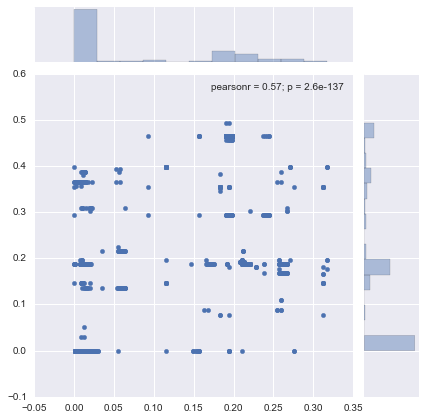

In [85]:
%%prun

result = paired_distances( 42333 )
seaborn.jointplot(result['guest distances'], result['host distances'] )

In [76]:
from random import shuffle
from itertools import combinations
from intbitset import intbitset

def sample_paired_distances( id, n ) :
    clade = intbitset(T1.get_leafs(id))
    l = filter( lambda x : x[0] in clade, F )
    nl = len(l)
    gpairs = zeros( (n,2), dtype=int )
    hpairs = zeros( (n,2), dtype=int )
    shuffle(l)
    for i,((g1,h1),(g2,h2)) in enumerate(combinations( l, 2 )) :
        if i >= n : break
        gpairs[i,0] = g1
        gpairs[i,1] = g2
        hpairs[i,0] = h1
        hpairs[i,1] = h2
    gd = T1.distances( gpairs )
    hd = T.distances(  hpairs )
    return { 'length' : len(clade), 'n_links' : len(l), 'guest distances' : gd, 'host distances' : hd }

In [78]:
%%prun

def sample_root_dist( n ) :
    result = sample_paired_distances( T1.root, n )
    return correlation( result['guest distances'], result['host distances'] )

samples = []
for i in xrange(10,100000,5000) :
    print i
    tests = []
    for j in xrange( 10 ) :
        r = sample_root_dist( i )
        tests.append( r )
    print std(tests)
    samples.append( tests )

10
0.0
5010
0.0
10010
0.0
15010
0.0
20010
0.0
25010
0.0
30010
0.0
35010
0.0
40010
0.0
45010
0.0
50010
0.0
55010
0.0
60010
0.0
65010
0.0
70010
0.0
75010
0.0
80010


KeyboardInterrupt: 

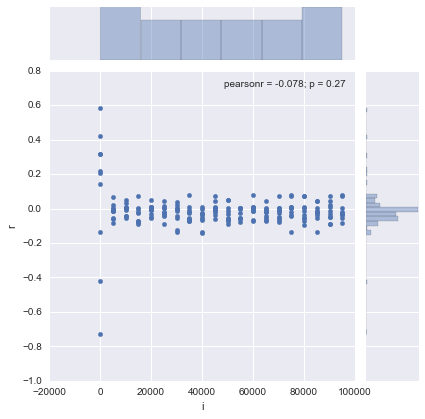

In [63]:
df = pd.DataFrame( samples )
seaborn.jointplot( 'i', 'r', data=df )

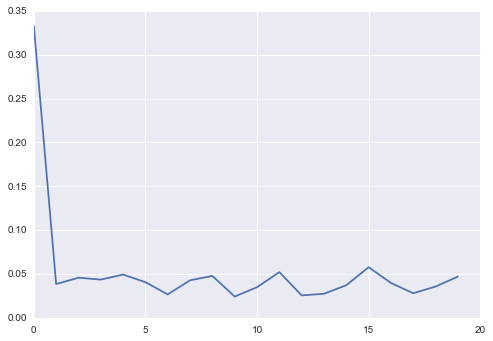

In [74]:
plot(map(std,samples))

In [40]:
from intbitset import intbitset

ibs_clade = intbitset(list(T1.get_leafs(T1.root)))
reg_clade = set(T1.get_leafs(T1.root))
%timeit l = filter( lambda x : x[0] in reg_clade, F )
%timeit l = filter( lambda x : x[0] in ibs_clade, F )

10 loops, best of 3: 67 ms per loop
10 loops, best of 3: 41.3 ms per loop


In [47]:
for n,((a,b),(c,d)) in enumerate(combinations( l, 2 )) :
    if n > 100 : break
print a

22206


In [80]:
tests

[0.0, 0.0, 0.0, 0.0, 0.0]